Import required packages

In [13]:
import pandas as pd
import numpy as np
import matplotlib
import os
from rake_nltk import Rake
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

#### Web Scraping - IMDb
Uncomment to run scraper, which will reload existing csv.
This scaper makes asynchronous requests to the IMDb Advanced Search page and fetches Top 250 movies by popularity for each year in 1990-2021. Random waits between each year's requests.

In [14]:
# import nest_asyncio
# nest_asyncio.apply()
# %run -i scrape_imdb.py

In [15]:
#read csv to dataframe
df = pd.read_csv('data.csv')
df['stars'].fillna('', inplace = True)
df.head(10)

,imdb_title_id,title,year,certificate,genre,runtime,description,IMDb_rating,MetaScore,ratingCount,directors,stars
0,tt0099685,Goodfellas,1990,R,"Biography, Crime, Drama",146 min,The story of Henry Hill and his life in the mo...,8.7,90.0,1044112,Martin Scorsese,"Robert De Niro,Ray Liotta,Joe Pesci,Lorraine B..."
1,tt0099785,Home Alone,1990,PG,"Comedy, Family",103 min,An eight-year-old troublemaker must protect hi...,7.6,63.0,497130,Chris Columbus,"Macaulay Culkin,Joe Pesci,Daniel Stern,John Heard"
2,tt0099487,Edward Scissorhands,1990,PG-13,"Drama, Fantasy, Romance",105 min,"An artificial man, who was incompletely constr...",7.9,74.0,453499,Tim Burton,"Johnny Depp,Winona Ryder,Dianne Wiest,Anthony ..."
3,tt0099088,Back to the Future Part III,1990,PG,"Adventure, Comedy, Sci-Fi",118 min,"Stranded in 1955, Marty McFly learns about the...",7.4,55.0,412989,Robert Zemeckis,"Michael J. Fox,Christopher Lloyd,Mary Steenbur..."
4,tt0099674,The Godfather: Part III,1990,R,"Crime, Drama",162 min,"Follows Michael Corleone, now in his 60s, as h...",7.6,60.0,368052,Francis Ford Coppola,"Al Pacino,Diane Keaton,Andy Garcia,Talia Shire"
5,tt0099423,Die Hard 2,1990,R,"Action, Thriller",124 min,John McClane attempts to avert disaster as rog...,7.1,67.0,342073,Renny Harlin,"Bruce Willis,William Atherton,Bonnie Bedelia,R..."
6,tt0100802,Total Recall,1990,R,"Action, Sci-Fi, Thriller",113 min,When a man goes in to have virtual vacation me...,7.5,57.0,307833,Paul Verhoeven,"Arnold Schwarzenegger,Sharon Stone,Michael Iro..."
7,tt0100405,Pretty Woman,1990,R,"Comedy, Romance",119 min,A man in a legal but hurtful business needs an...,7.0,51.0,296814,Garry Marshall,"Richard Gere,Julia Roberts,Jason Alexander,Lau..."
8,tt0099348,Dances with Wolves,1990,PG-13,"Adventure, Drama, Western",181 min,"Lieutenant John Dunbar, assigned to a remote w...",8.0,72.0,245602,Kevin Costner,"Kevin Costner,Mary McDonnell,Graham Greene,Rod..."
9,tt0099653,Ghost,1990,PG-13,"Drama, Fantasy, Romance",127 min,"After a young man is murdered, his spirit stay...",7.1,52.0,201225,Jerry Zucker,"Patrick Swayze,Demi Moore,Whoopi Goldberg,Tony..."


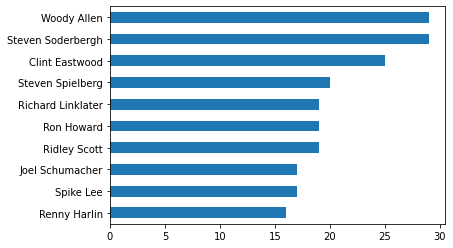

In [16]:
df['directors'].value_counts()[0:10].plot(kind='barh').invert_yaxis()

In [17]:
df.sort_values(['IMDb_rating','ratingCount'],ascending=[False,False]).head()

,imdb_title_id,title,year,certificate,genre,runtime,description,IMDb_rating,MetaScore,ratingCount,directors,stars
1000,tt0111161,The Shawshank Redemption,1994,R,Drama,142 min,Two imprisoned men bond over a number of years...,9.3,80.0,2398475,Frank Darabont,"Tim Robbins,Morgan Freeman,Bob Gunton,William ..."
4500,tt0468569,The Dark Knight,2008,PG-13,"Action, Crime, Drama",152 min,When the menace known as the Joker wreaks havo...,9.0,84.0,2359640,Christopher Nolan,"Christian Bale,Heath Ledger,Aaron Eckhart,Mich..."
675,tt0259534,Ramayana: The Legend of Prince Rama,1992,PG,"Animation, Action, Adventure",170 min,An anime adaptation of the Hindu epic the Rama...,9.0,NaN,2506,"Ram Mohan,Yûgô Sakô,Koichi Saski","Bryan Cranston,Arun Govil,Edie Mirman,Rael Pad..."
1001,tt0110912,Pulp Fiction,1994,R,"Crime, Drama",154 min,"The lives of two mob hitmen, a boxer, a gangst...",8.9,94.0,1864905,Quentin Tarantino,"John Travolta,Uma Thurman,Samuel L. Jackson,Br..."
3250,tt0167260,The Lord of the Rings: The Return of the King,2003,PG-13,"Action, Adventure, Drama",201 min,Gandalf and Aragorn lead the World of Men agai...,8.9,94.0,1674567,Peter Jackson,"Elijah Wood,Viggo Mortensen,Ian McKellen,Orlan..."


In [18]:
#Extract keywords
r = Rake()
def rake_implement(x,r):
     r.extract_keywords_from_text(x)
     return r.get_ranked_phrases()

df['keywords'] =df['description'].apply(lambda x: rake_implement(x,r))

In [19]:
df['genre']     = df['genre'].map(lambda x: x.split(','))
df['stars']     = df['stars'].map(lambda x: x.split(','))
df['directors'] = df['directors'].map(lambda x: x.split(','))

for index, row in df.iterrows():
     df.at[index,'genre']     = [x.lower().replace(' ','') for x in row['genre']]
     df.at[index,'stars']     = [x.lower().replace(' ','') for x in row['stars']]
     df.at[index,'directors'] = [x.lower().replace(' ','') for x in row['directors']]

In [20]:
df.head()

,imdb_title_id,title,year,certificate,genre,runtime,description,IMDb_rating,MetaScore,ratingCount,directors,stars,keywords
0,tt0099685,Goodfellas,1990,R,"[biography, crime, drama]",146 min,The story of Henry Hill and his life in the mo...,8.7,90.0,1044112,[martinscorsese],"[robertdeniro, rayliotta, joepesci, lorrainebr...","[mob partners jimmy conway, american crime syn..."
1,tt0099785,Home Alone,1990,PG,"[comedy, family]",103 min,An eight-year-old troublemaker must protect hi...,7.6,63.0,497130,[chriscolumbus],"[macaulayculkin, joepesci, danielstern, johnhe...","[old troublemaker must protect, accidentally l..."
2,tt0099487,Edward Scissorhands,1990,PG-13,"[drama, fantasy, romance]",105 min,"An artificial man, who was incompletely constr...",7.9,74.0,453499,[timburton],"[johnnydepp, winonaryder, diannewiest, anthony...","[suburban lady meets, solitary life, one day, ..."
3,tt0099088,Back to the Future Part III,1990,PG,"[adventure, comedy, sci-fi]",118 min,"Stranded in 1955, Marty McFly learns about the...",7.4,55.0,412989,[robertzemeckis],"[michaelj.fox, christopherlloyd, marysteenburg...","[two must figure, must travel back, marty mcfl..."
4,tt0099674,The Godfather: Part III,1990,R,"[crime, drama]",162 min,"Follows Michael Corleone, now in his 60s, as h...",7.6,60.0,368052,[francisfordcoppola],"[alpacino, dianekeaton, andygarcia, taliashire]","[follows michael corleone, suitable successor,..."


In [21]:
df['bagofwords'] = ''

#mentioning multiple times to increase weight
columns = ['genre', 'directors', 'stars','genre', 'directors', 'stars', 'keywords']
for index, row in df.iterrows():
    words = ''
    for col in columns:
        words += ' '.join(row[col]) + ' '
    df.at[index,'bagofwords'] = words
df = df[['title','bagofwords']]
df.to_csv('final.csv')

In [22]:
count = CountVectorizer()
count_matrix = count.fit_transform(df['bagofwords'])
cosine_sim = cosine_similarity(count_matrix, count_matrix)
# filesize too large 
# np.save('cosine_sim.npy', cosine_sim)

In [23]:
indices = pd.Series(df['title'])

In [28]:
def recomovie(title, cosine_sim = cosine_sim):
    recommended_movies = []
    idx = indices[indices == title].index[0]
    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)
    top_10_indices = list(score_series.iloc[1:11].index)
    
    for i in top_10_indices:
        recommended_movies.append(list(df['title'])[i])
        
    return recommended_movies

In [29]:
recomovie('Rocky V')

['Rocky Balboa',
 'The Power of One',
 '8 Seconds',
 'Driven',
 'Creed II',
 'Creed',
 'Grudge Match',
 'Inferno',
 'Hardball',
 'The Express']